In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json
import glob
import os

/home/bota/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [34]:
json_file = "merged_results/merged_full_results.json"
rows = []

with open(json_file, "r") as f:
    data = json.load(f)
    for phase, phase_data in data.items():
        for exp_type, runs in phase_data.items():
            for run in runs:
                # Experiment naming convention: ultra_fast_gaussian_edge_rep{i}
                name_parts = run["experiment_name"].split("_")
                rep_idx = (
                    int(name_parts[-1].replace("rep", ""))
                    if "rep" in name_parts[-1]
                    else None
                )

                row = {
                    "phase": phase,
                    "experiment_type": exp_type,
                    "field_type": run.get("field_type"),
                    "start_position": run.get("start_position"),
                    "rep": rep_idx,
                }
                # Add main metrics
                initial_entropy = (
                    run["entropy_timeline"][0] if "entropy_timeline" in run else None
                )
                final_entropy = run.get("final_entropy")
                entropy_reduction = (
                    initial_entropy - final_entropy
                    if initial_entropy and final_entropy
                    else run.get("entropy_reduction")
                )
                row["entropy_reduction"] = entropy_reduction
                row["final_mse"] = run.get("final_mse")
                # Use final coverage from timeline if available, else coverage_percentage
                coverage_end = (
                    run["coverage_timeline"][-1]
                    if "coverage_timeline" in run and run["coverage_timeline"]
                    else run.get("coverage_percentage")
                )
                row["coverage_end"] = coverage_end
                row["avg_planning_time_per_step"] = run.get(
                    "avg_planning_time_per_step"
                )
                rows.append(row)

df = pd.DataFrame(rows)
df.to_csv("raw.csv", index=False)

In [5]:
# Group and aggregate metrics
group_cols = ["phase", "experiment_type", "field_type", "start_position"]
agg_metrics = {
    "entropy_reduction": ["mean", "std", "min", "max"],
    "final_mse": ["mean", "std", "min", "max"],
    "coverage_end": ["mean", "std", "min", "max"],
    "avg_planning_time_per_step": ["mean", "std", "min", "max"],
}

summary = df.groupby(group_cols).agg(agg_metrics)
summary.columns = ["_".join(col).strip() for col in summary.columns.values]
summary.reset_index(inplace=True)

# summary.to_csv("summary_main_metrics.csv", index=False)
print(summary.head())

print(summary.keys())

                          phase experiment_type field_type start_position  \
0  phase_1_computational_budget        balanced   Gaussian         corner   
1  phase_1_computational_budget        balanced   Gaussian           edge   
2  phase_1_computational_budget      exhaustive   Gaussian         corner   
3  phase_1_computational_budget      exhaustive   Gaussian           edge   
4  phase_1_computational_budget            fast   Gaussian         corner   

   entropy_reduction_mean  entropy_reduction_std  entropy_reduction_min  \
0           135866.708185            8299.202679          118030.986619   
1           136149.734961            4292.916534          127827.391826   
2           123984.949227            8512.899598          106936.794488   
3           126754.908954            8101.970001          114763.443975   
4           138521.497784            5657.539142          127703.267566   

   entropy_reduction_max  final_mse_mean  final_mse_std  final_mse_min  \
0          1

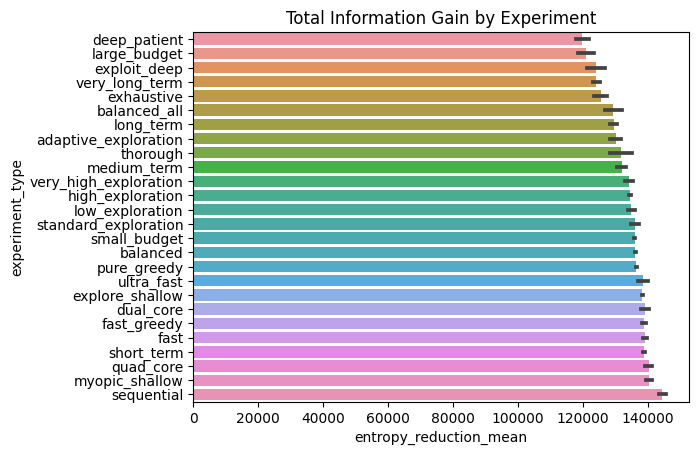

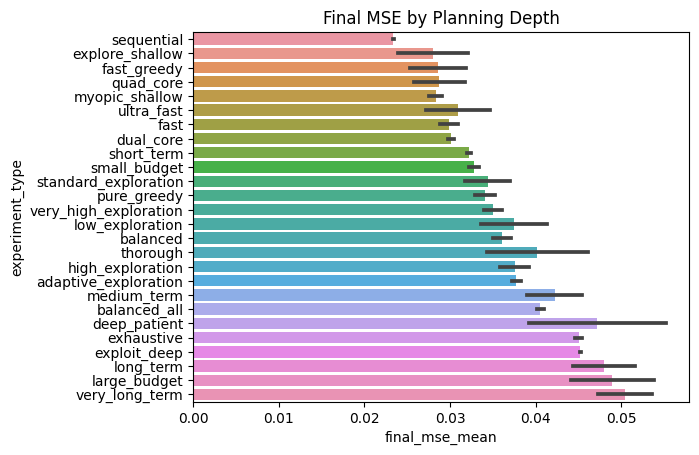

In [ ]:
# # # Barplot: Mean info gain by experiment, sorted by x
sorted_summary = summary.sort_values(by="entropy_reduction_mean")
sns.barplot(
    x="entropy_reduction_mean", y="experiment_type", data=sorted_summary, errorbar="sd"
)
plt.title("Total Information Gain by Experiment")
plt.show()

# Boxplot: Final MSE by planning depth

sorted_summary = summary.sort_values(by="final_mse_mean")
sns.barplot(x="final_mse_mean", y="experiment_type", data=sorted_summary, errorbar="sd")
plt.title("Final MSE by Planning Depth")
plt.show()


# # Lineplot: planning depth vs. mean info gain
# sns.lineplot(
#     x="planning_depth", y="total_information_gain", data=df, estimator="mean"
# )
# plt.title("Planning Depth vs Mean Information Gain")
# plt.show()

# # Heatmap: planning_depth vs ucb1_c for info gain
# pivot = df.pivot_table(
#     index="planning_depth",
#     columns="ucb1_c",
#     values="total_information_gain",
#     aggfunc="mean",
# )
# sns.heatmap(pivot, annot=True, cmap="viridis")
# plt.title("Info Gain: Planning Depth vs UCB1_c")
# plt.show()

# # Scatterplot: info gain vs avg planning time
# sns.scatterplot(
#     x="avg_planning_time_per_step",
#     y="total_information_gain",
#     hue="experiment_name",
#     data=df,
# )
# plt.title("Information Gain vs Average Planning Time per Step")
# plt.show()

# # Lineplot: entropy timeline for a single run
# run = df[df["experiment_name"] == "ultra_fast_Gaussian_corner_rep0"].iloc[0]
# plt.plot(run["entropy_timeline"])
# plt.title("Entropy Reduction Over Steps (Ultra Fast)")
# plt.xlabel("Step")
# plt.ylabel("Entropy")
# plt.show()

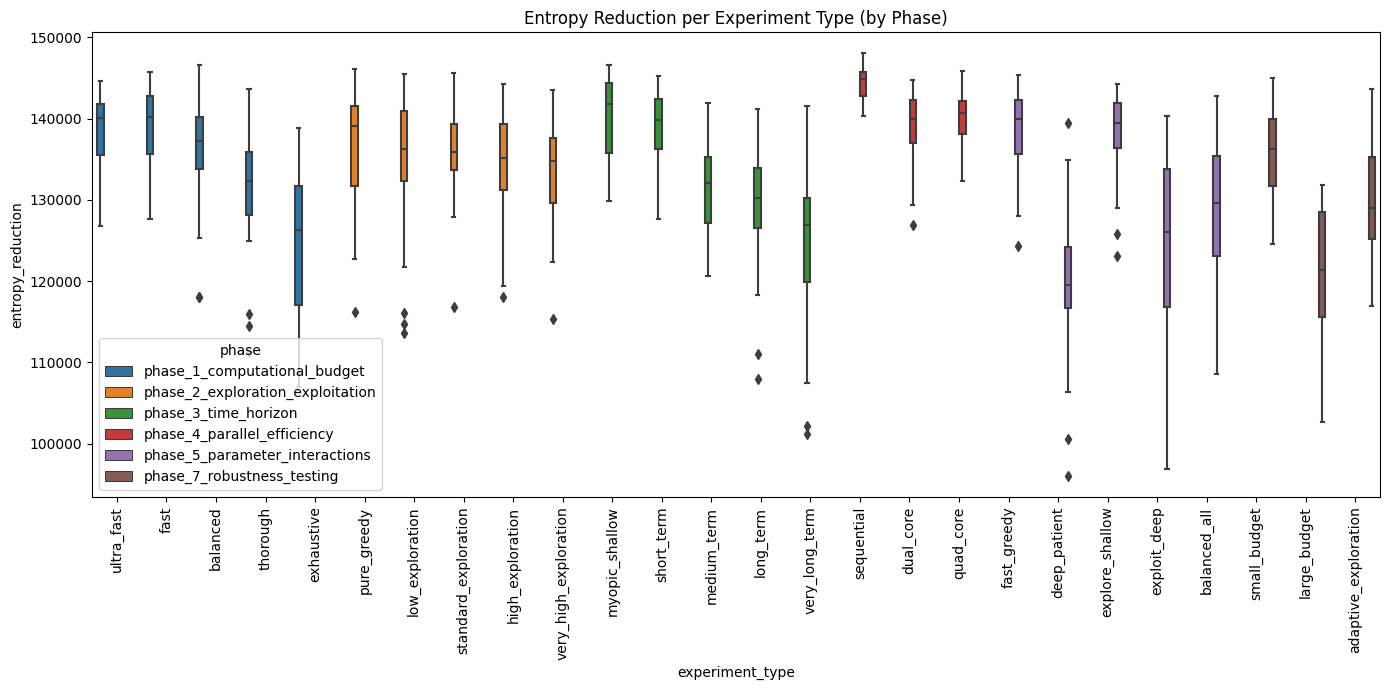

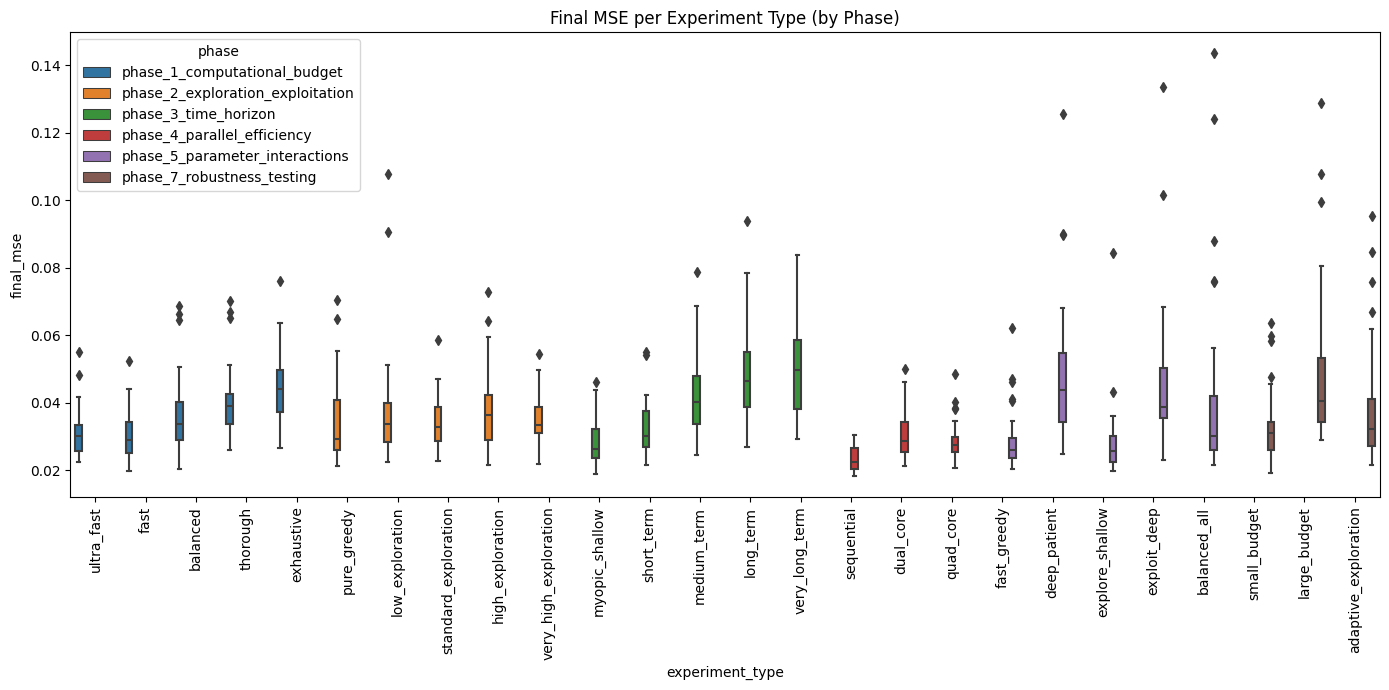

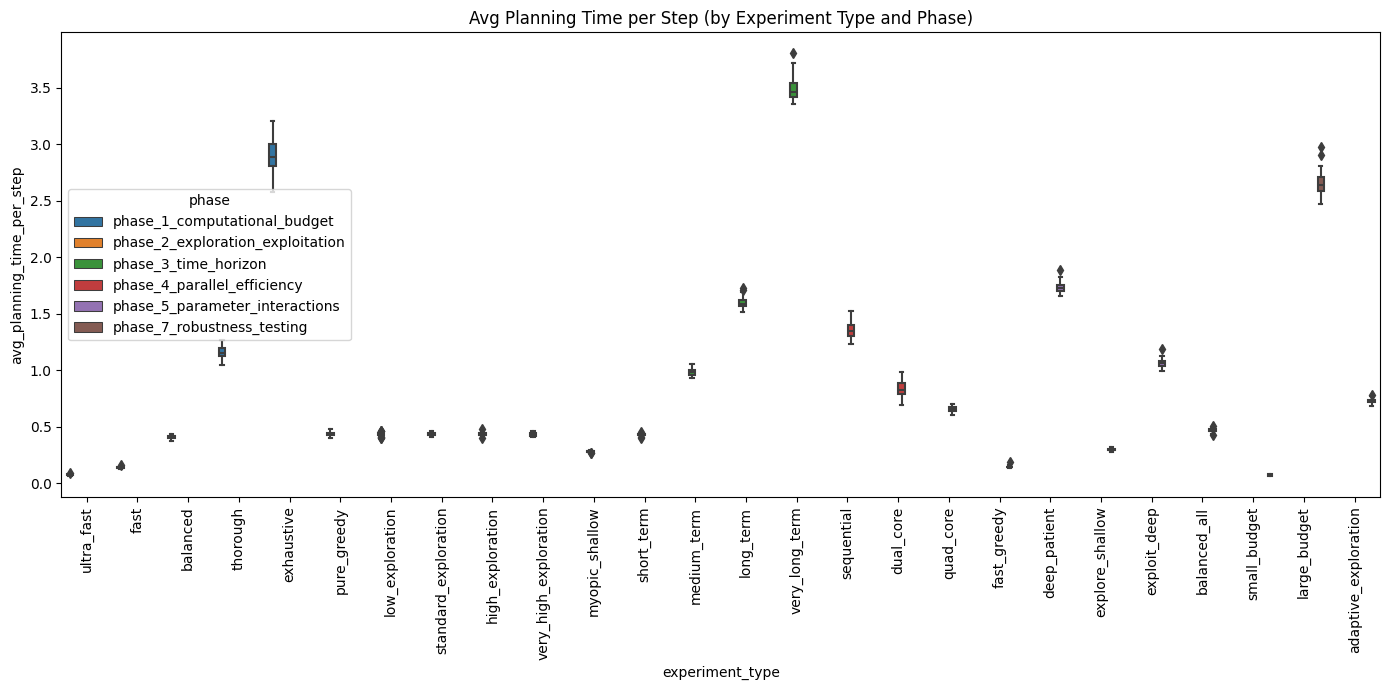

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your aggregated DataFrame
df = pd.read_csv("aggregated_mcts_results.csv")

# ----------- Boxplots: Distribution over repetitions ------------

# Entropy Reduction
plt.figure(figsize=(14, 7))
sns.boxplot(x="experiment_type", y="entropy_reduction", hue="phase", data=df)
plt.title("Entropy Reduction per Experiment Type (by Phase)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Final MSE
plt.figure(figsize=(14, 7))
sns.boxplot(x="experiment_type", y="final_mse", hue="phase", data=df)
plt.title("Final MSE per Experiment Type (by Phase)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Coverage End
plt.figure(figsize=(14, 7))
sns.boxplot(x="experiment_type", y="coverage_end", hue="phase", data=df)
plt.title("Final Coverage per Experiment Type (by Phase)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Avg Planning Time per Step
plt.figure(figsize=(14, 7))
sns.boxplot(x="experiment_type", y="avg_planning_time_per_step", hue="phase", data=df)
plt.title("Avg Planning Time per Step (by Experiment Type and Phase)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

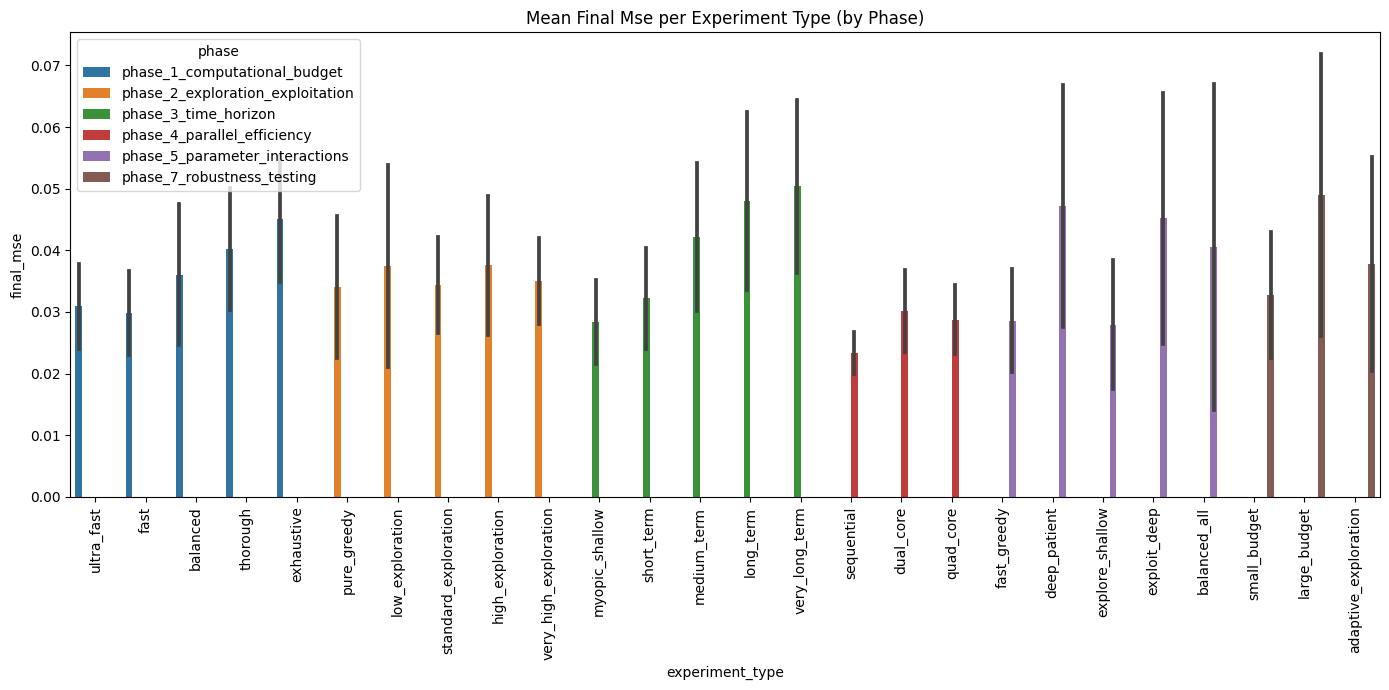

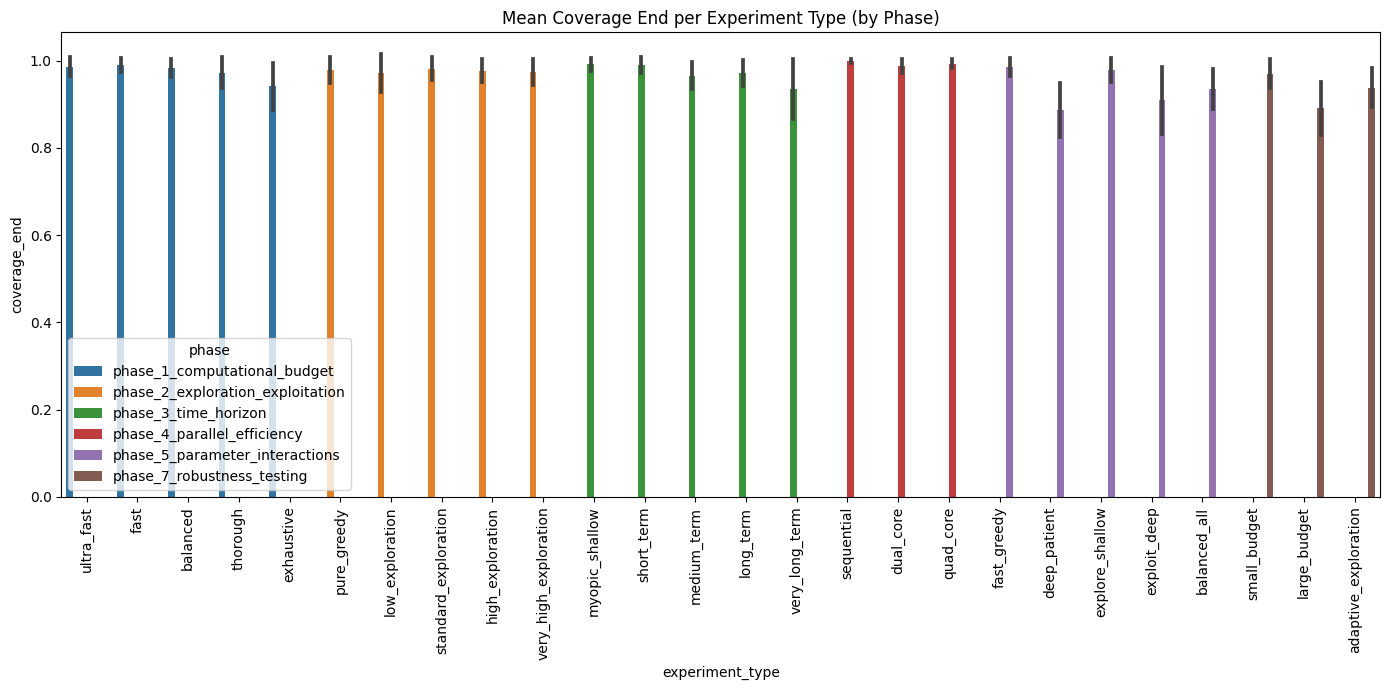

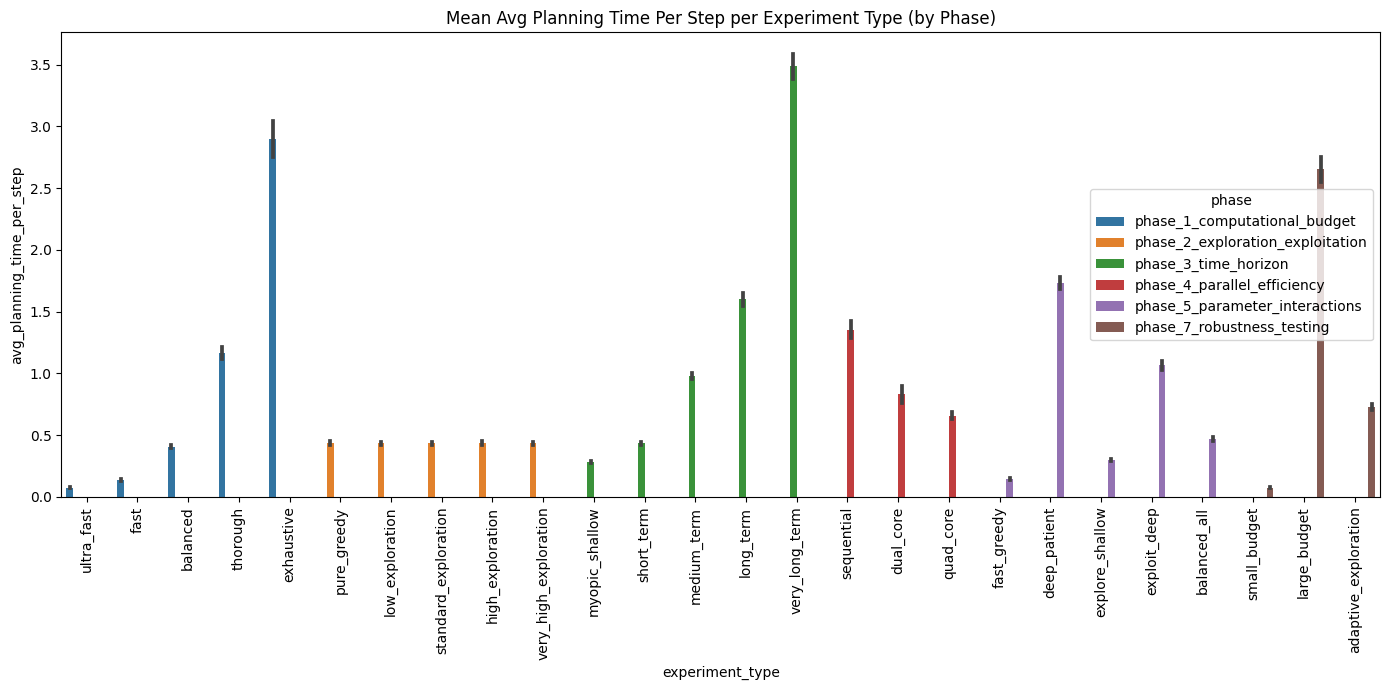

In [ ]:
# ----------- Barplots: Mean values for quick comparison ------------

metrics = [
    "entropy_reduction",
    "final_mse",
    "coverage_end",
    "avg_planning_time_per_step",
]
for metric in metrics:
    plt.figure(figsize=(14, 7))
    sns.barplot(
        x="experiment_type",
        y=metric,
        hue="phase",
        data=df,
        errorbar="sd",
        estimator="mean",
    )
    plt.title(f"Mean {metric.replace('_', ' ').title()} per Experiment Type (by Phase)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

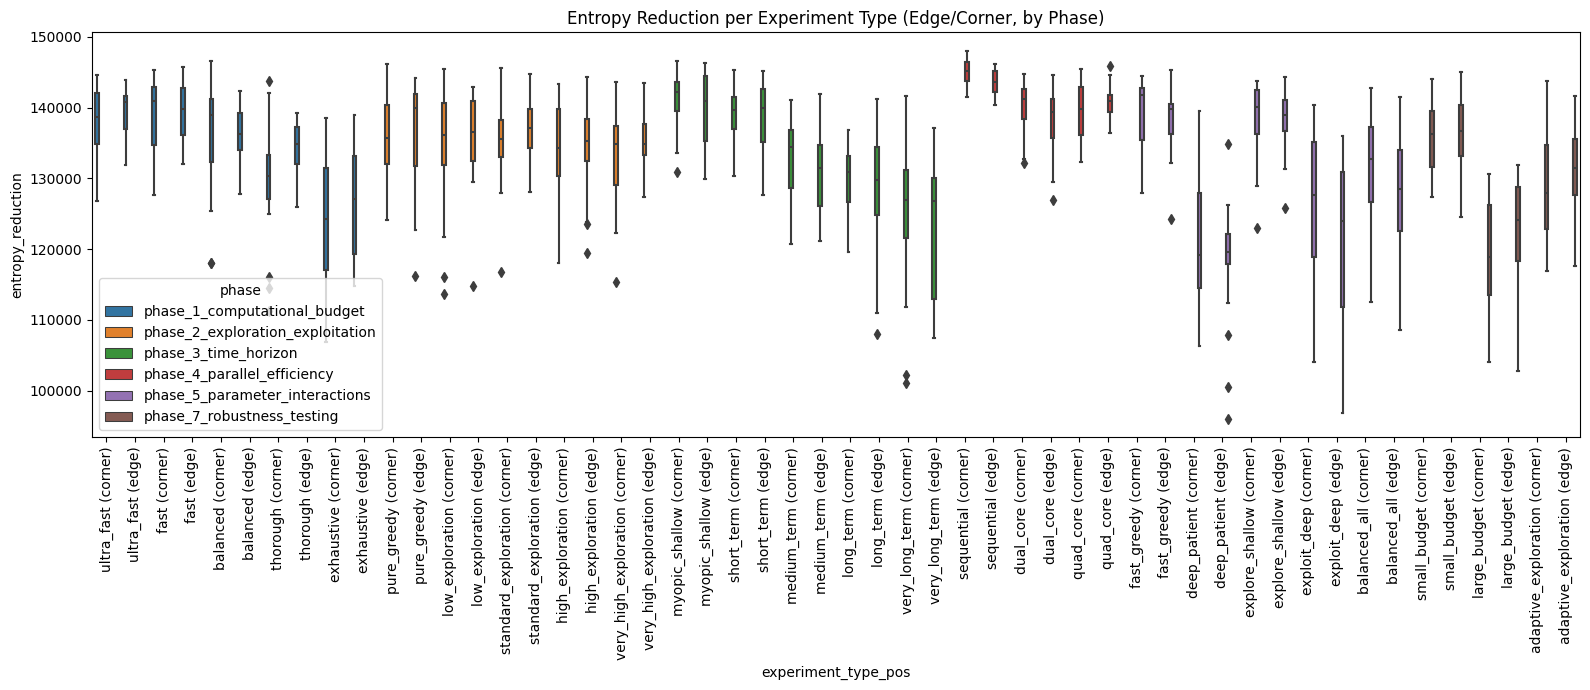

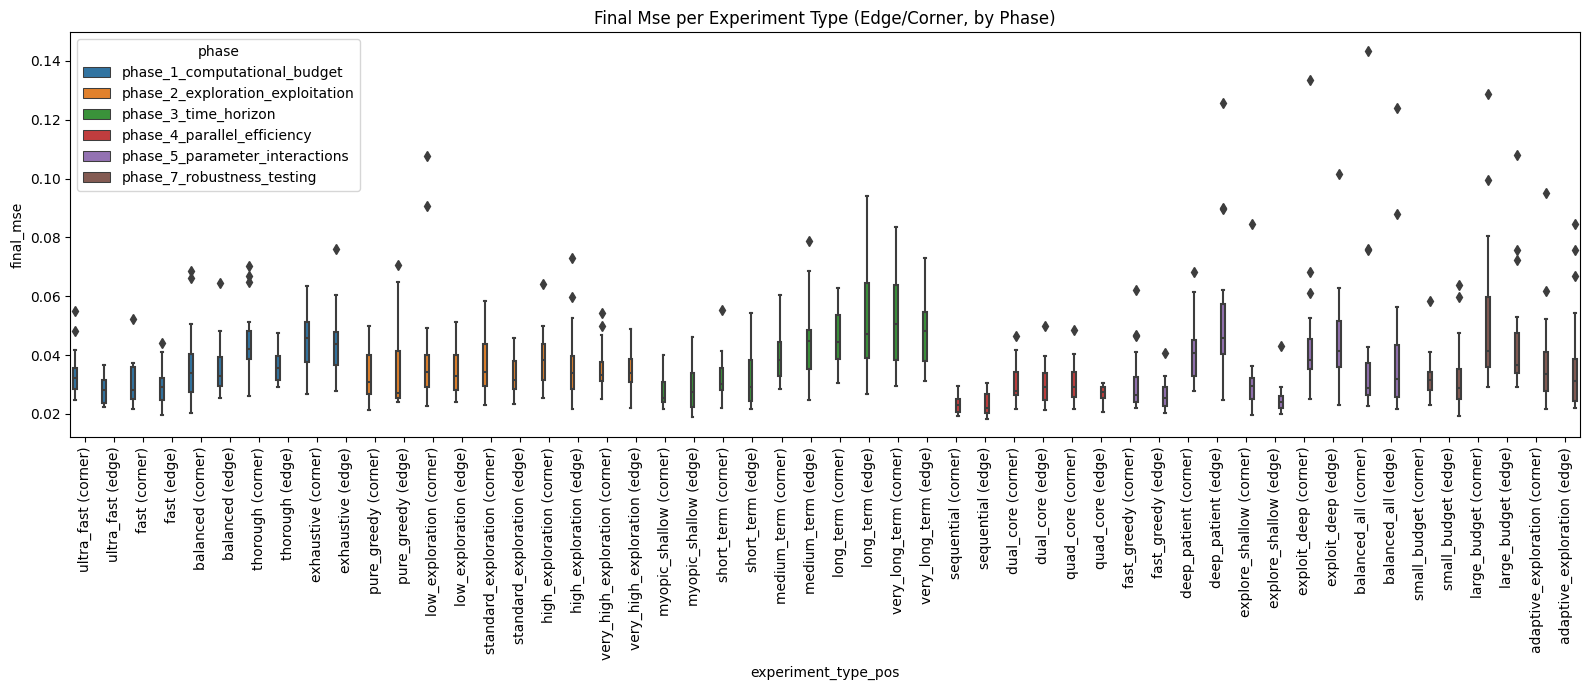

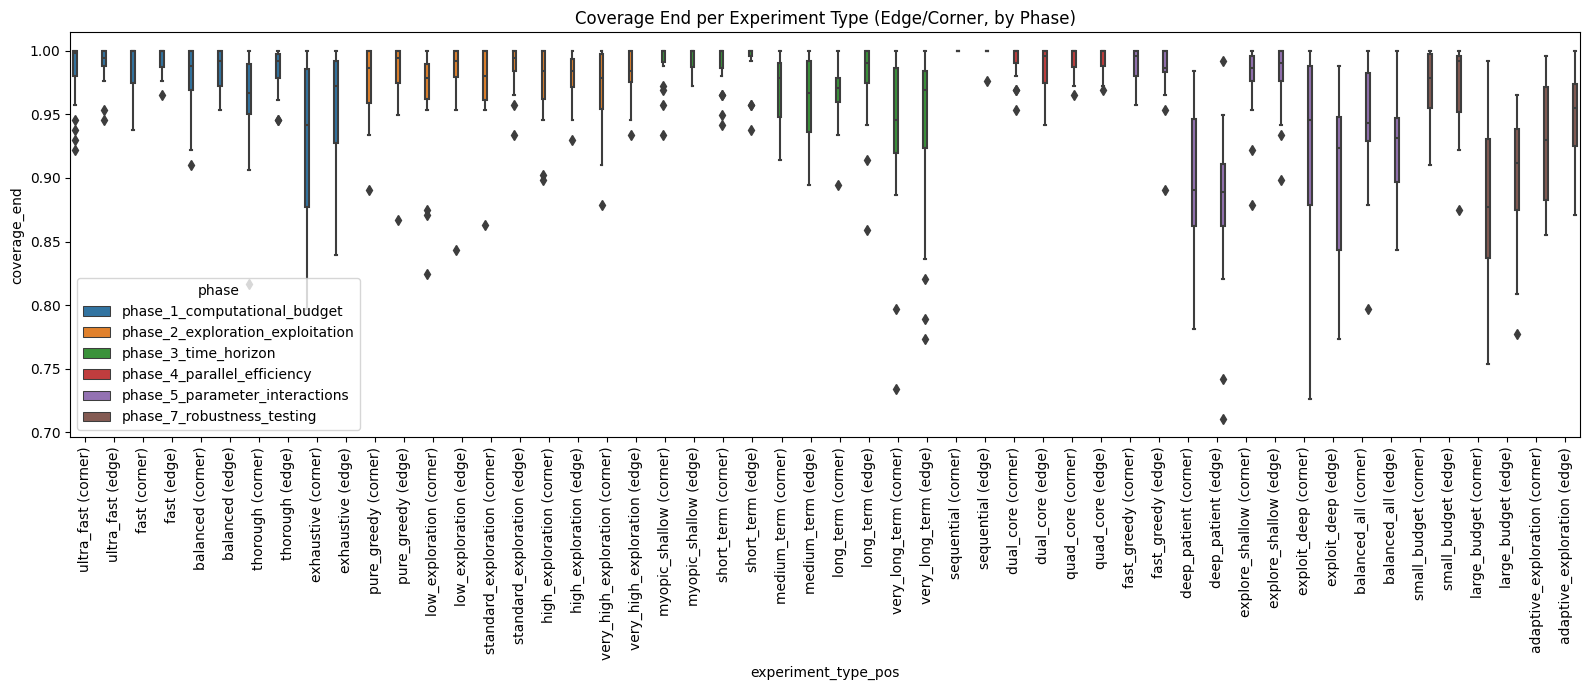

In [32]:
df["experiment_type_pos"] = df["experiment_type"] + " (" + df["start_position"] + ")"

for metric in metrics:
    plt.figure(figsize=(16, 7))
    sns.boxplot(
        x="experiment_type_pos",
        y=metric,
        hue="phase",
        data=df,
    )
    plt.title(
        f"{metric.replace('_', ' ').title()} per Experiment Type (Edge/Corner, by Phase)"
    )
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [44]:
# ----------- Scatterplot: Entropy Reduction vs. Planning Time ------------

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="avg_planning_time_per_step",
    y="entropy_reduction",
    style="experiment_type",
    hue="phase",
    data=df,
)
plt.title("Entropy Reduction vs. Avg Planning Time per Step")
plt.tight_layout()
plt.show()


=== phase_1_computational_budget ===


/tmp/ipykernel_1263495/149897096.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase_df["legend_label"] = phase_df.apply(build_label, axis=1)


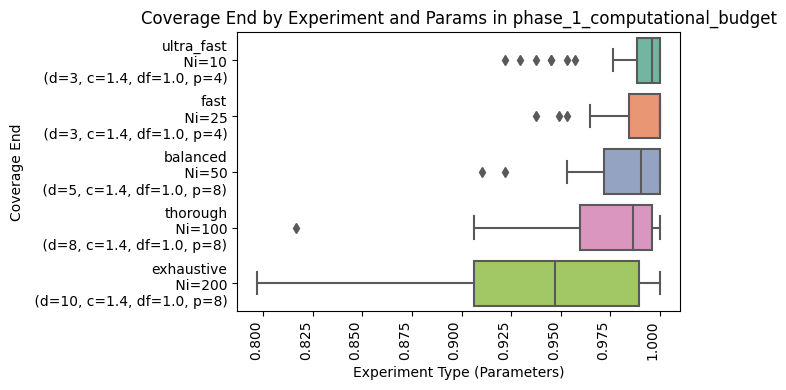

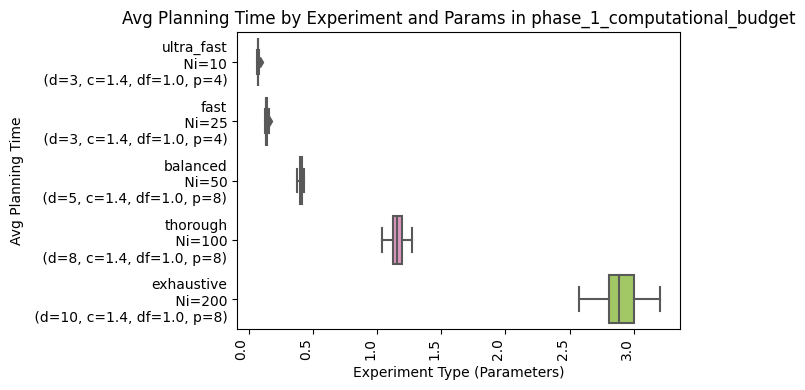


=== phase_2_exploration_exploitation ===


/tmp/ipykernel_1263495/149897096.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase_df["legend_label"] = phase_df.apply(build_label, axis=1)


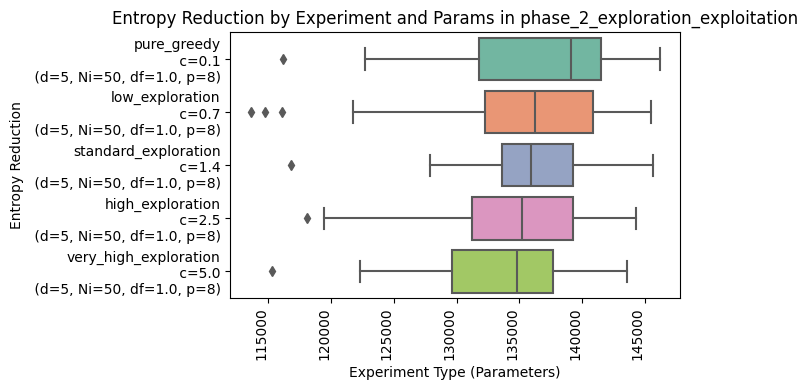

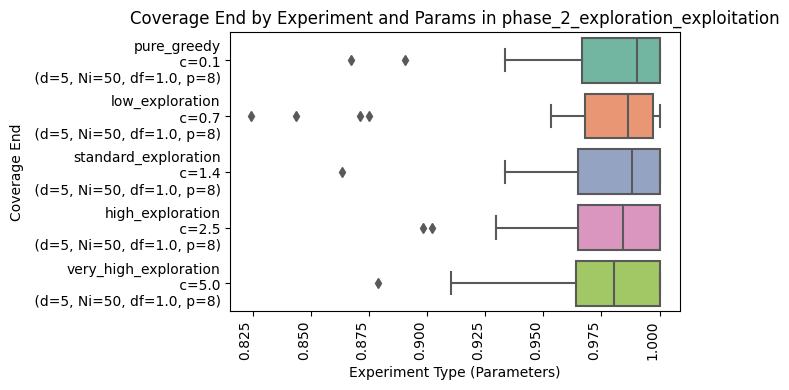


=== phase_3_time_horizon ===


/tmp/ipykernel_1263495/149897096.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase_df["legend_label"] = phase_df.apply(build_label, axis=1)


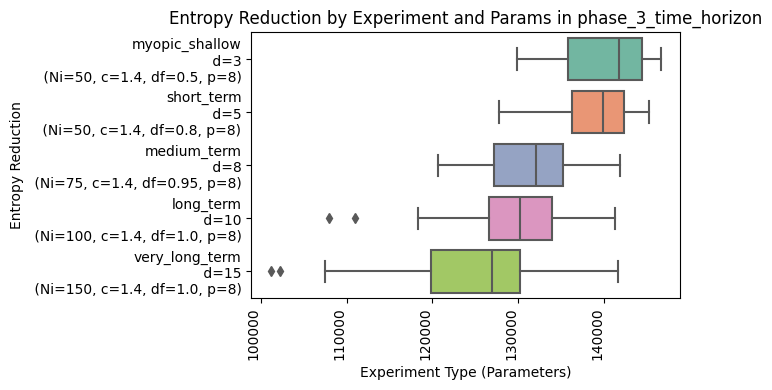

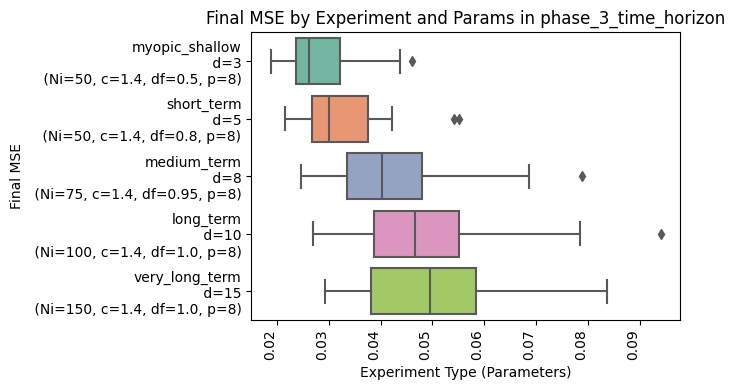


=== phase_4_parallel_efficiency ===


/tmp/ipykernel_1263495/149897096.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase_df["legend_label"] = phase_df.apply(build_label, axis=1)


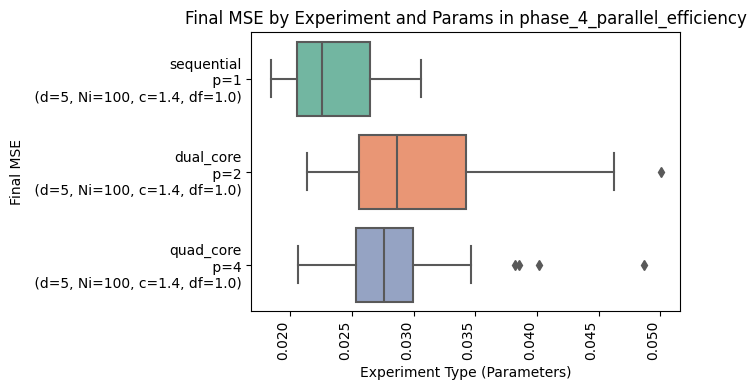

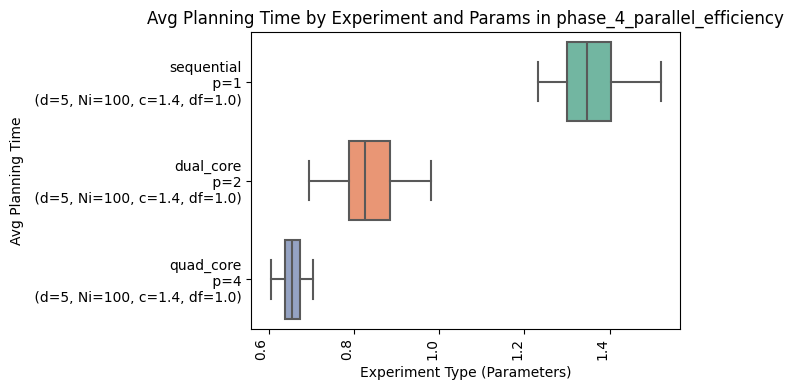


=== phase_5_parameter_interactions ===


/tmp/ipykernel_1263495/149897096.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase_df["legend_label"] = phase_df.apply(build_label, axis=1)


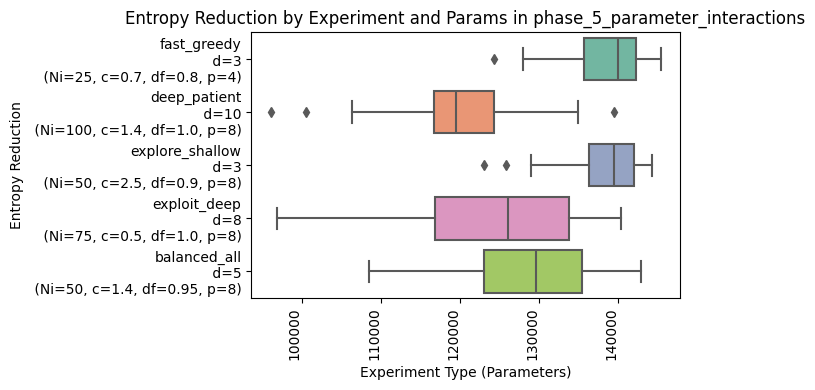

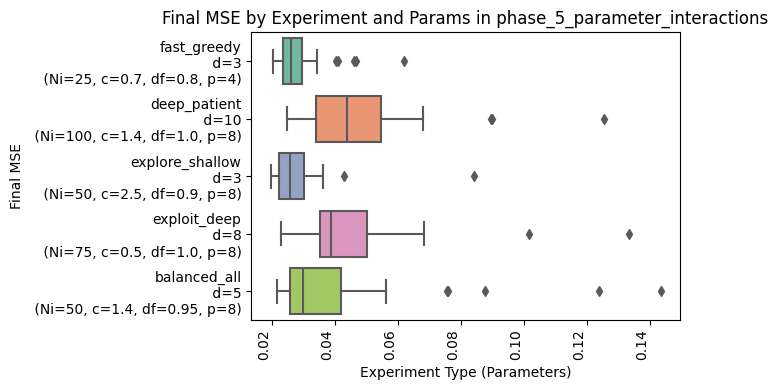

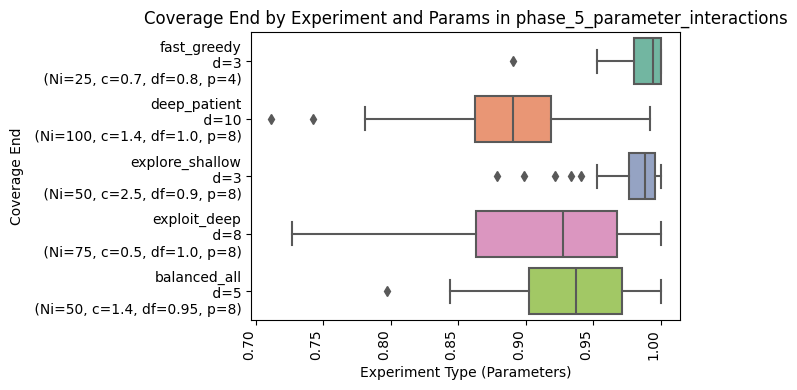

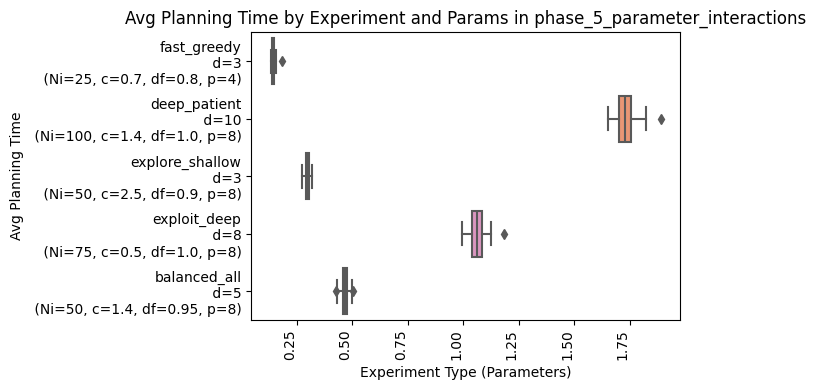


=== phase_7_robustness_testing ===


/tmp/ipykernel_1263495/149897096.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase_df["legend_label"] = phase_df.apply(build_label, axis=1)


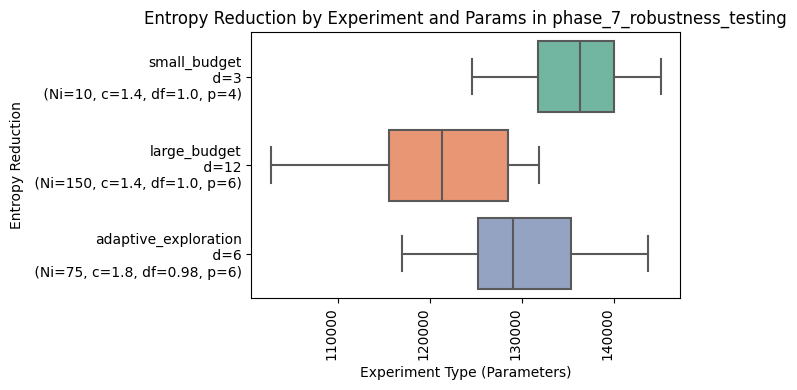

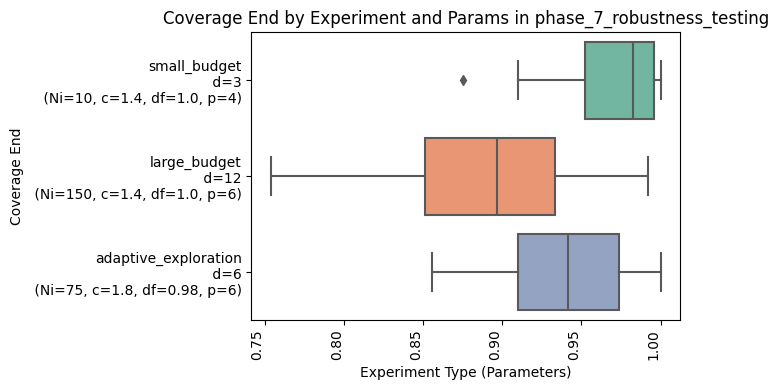

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your aggregated DataFrame
df = pd.read_csv("aggregated_mcts_results.csv")

# Parameter abbreviation mapping
param_abbr = {
    "planning_depth": "d",
    "num_iterations": "Ni",
    "ucb1_c": "c",
    "discount_factor": "df",
    "parallel": "p",
}

# Metrics
metrics = [
    ("entropy_reduction", "Entropy Reduction"),
    ("final_mse", "Final MSE"),
    ("coverage_end", "Coverage End"),
    ("avg_planning_time_per_step", "Avg Planning Time"),
]

for phase in df["phase"].unique():
    phase_df = df[df["phase"] == phase]
    print(f"\n=== {phase} ===")
    # Find main changing param in this phase
    param_variation = {p: phase_df[p].nunique() for p in param_abbr}
    main_param = max(
        param_variation, key=param_variation.get
    )  # param with most variation

    # Build legend labels for each experiment type
    def build_label(row):
        vals = [f"{param_abbr[p]}={row[p]}" for p in param_abbr]
        # Highlight main param, others in brackets
        main_val = f"{param_abbr[main_param]}={row[main_param]}"
        other_vals = ", ".join(
            [v for v in vals if not v.startswith(f"{param_abbr[main_param]}=")]
        )
        return f"{row['experiment_type']}\n {main_val}\n ({other_vals})"

    phase_df["legend_label"] = phase_df.apply(build_label, axis=1)

    for metric, metric_label in metrics:
        plt.figure(figsize=(7, 4))
        # Boxplot with legend as experiment type + params
        sns.boxplot(y="legend_label", x=metric, data=phase_df, palette="Set2")
        plt.title(f"{metric_label} by Experiment and Params in {phase}")
        plt.xlabel("Experiment Type (Parameters)")
        plt.ylabel(metric_label)
        plt.xticks(rotation=90, ha="right")
        plt.tight_layout()
        plt.show()

# Data prep


In [35]:
import json
import pandas as pd

json_file = "merged_results/merged_full_results.json"
rows = []

with open(json_file, "r") as f:
    data = json.load(f)
    for phase, phase_data in data.items():
        for exp_type, runs in phase_data.items():
            for run in runs:
                row = {
                    "phase": phase,
                    "experiment_type": exp_type,
                    "experiment_name": run.get("experiment_name"),
                    "field_type": run.get("field_type"),
                    "start_position": run.get("start_position"),
                }
                # Extract parameters!
                if "parameters" in run:
                    for k, v in run["parameters"].items():
                        row[k] = v
                # Metrics
                initial_entropy = (
                    run["entropy_timeline"][0] if "entropy_timeline" in run else None
                )
                final_entropy = run.get("final_entropy")
                entropy_reduction = (
                    initial_entropy - final_entropy
                    if initial_entropy and final_entropy
                    else run.get("entropy_reduction")
                )
                row["entropy_reduction"] = entropy_reduction
                row["final_mse"] = run.get("final_mse")
                coverage_end = (
                    run["coverage_timeline"][-1]
                    if "coverage_timeline" in run and run["coverage_timeline"]
                    else run.get("coverage_percentage")
                )
                row["coverage_end"] = coverage_end
                row["avg_planning_time_per_step"] = run.get(
                    "avg_planning_time_per_step"
                )
                rows.append(row)

df = pd.DataFrame(rows)
df.to_csv("aggregated_mcts_results.csv", index=False)
print(df.columns)

Index(['phase', 'experiment_type', 'experiment_name', 'field_type',
       'start_position', 'planning_depth', 'num_iterations', 'timeout',
       'ucb1_c', 'parallel', 'discount_factor', 'entropy_reduction',
       'final_mse', 'coverage_end', 'avg_planning_time_per_step'],
      dtype='object')


In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your aggregated DataFrame
# df = pd.read_csv("raw.csv")
df = pd.read_csv("aggregated_mcts_results.csv")
# List main metrics and relevant parameters
metrics = [
    ("entropy_reduction", "Entropy Reduction"),
    ("final_mse", "Final MSE"),
    ("coverage_end", "Coverage"),
    ("avg_planning_time_per_step", "Avg Planning Time Per Step"),
]
param_labels = {
    "planning_depth": "Depth",
    "num_iterations": "Iterations",
    "ucb1_c": "UCB1_c",
    "parallel": "Parallel",
    "discount_factor": "Discount",
}
# Parameter abbreviation mapping
param_abbr = {
    "planning_depth": "d",
    "num_iterations": "Ni",
    "ucb1_c": "c",
    "discount_factor": "df",
    "parallel": "p",
}

In [54]:
import matplotlib.colors as mcolors


def plot_phase(phase_df, phase_name):

    field_type = phase_df["field_type"].unique()[0]

    # Get unique legend labels and assign colors
    unique_labels = phase_df["legend_label"].unique()
    palette = sns.color_palette("tab20", n_colors=len(unique_labels))
    color_map = dict(zip(unique_labels, palette))

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    fig.suptitle(
        field_type + " field: " + phase_name,
        fontsize=20,
    )

    for i, (metric, metric_label) in enumerate(metrics):
        sns.boxplot(
            x="legend_label",
            y=metric,
            data=phase_df,
            palette=color_map,
            ax=axes[i],
        )
        axes[i].set_title(f"{metric_label}")
        axes[i].set_xlabel("")
        axes[i].set_ylabel(metric_label)
        axes[i].set_xticks([])

    # Add legend only once (last axis)
    handles = [
        plt.Line2D([0], [0], color=color_map[label], lw=6, label=label)
        for label in unique_labels
    ]
    axes[-1].legend(
        handles=handles,
        title="Experiment Type (Params)",
        bbox_to_anchor=(1.05, 1),
        # loc="upper left",
    )

    plt.tight_layout()
    plt.show()

In [37]:
df["phase"].unique()

array(['phase_1_computational_budget', 'phase_2_exploration_exploitation',
       'phase_3_time_horizon', 'phase_4_parallel_efficiency',
       'phase_5_parameter_interactions', 'phase_7_robustness_testing'],
      dtype=object)

# phase 1: comp budget

mainly changed depth (d) and number of iteration (Ni) for the planner

In [48]:
phase = "phase_1_computational_budget"
phase1_df = df[df["phase"] == phase].copy()
param_variation = {p: phase1_df[p].nunique() for p in param_abbr}


def build_label(row):
    vals = [f"{param_abbr[p]}={row[p]}" for p in param_abbr]
    params = ", ".join([v for v in vals]) + " " + row["start_position"]
    return f"{row['experiment_type']}\n({params})"


phase1_df["legend_label"] = phase1_df.apply(build_label, axis=1)

In [55]:
plot_phase(phase1_df, "computational_budget")

# Phase 2: exploration vs exploitation

changes ubc_c coefficient for the planner

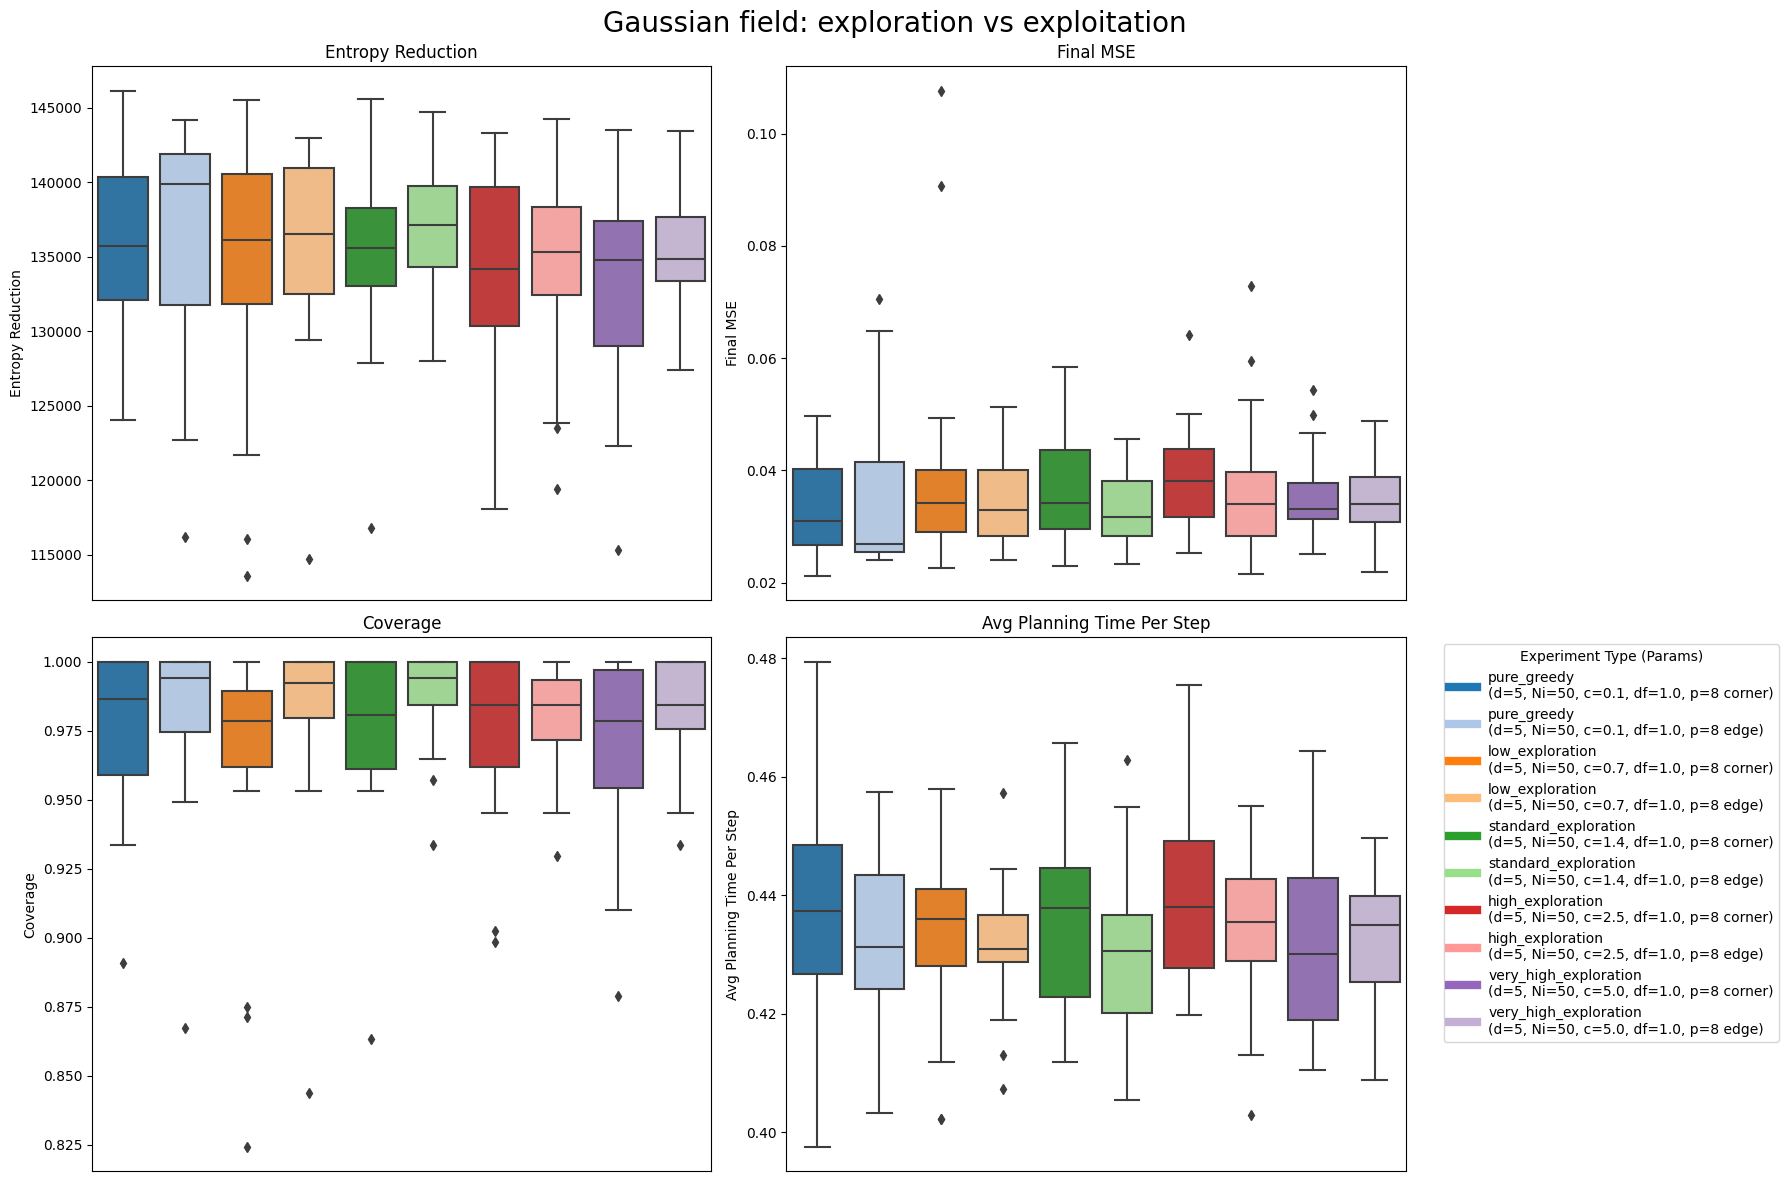

In [59]:
phase = "phase_2_exploration_exploitation"
phase2_df = df[df["phase"] == phase].copy()
param_variation = {p: phase2_df[p].nunique() for p in param_abbr}

phase2_df["legend_label"] = phase2_df.apply(build_label, axis=1)
plot_phase(phase2_df, "exploration vs exploitation")

In [60]:
phase = "phase_3_time_horizon"
phase3_df = df[df["phase"] == phase].copy()
param_variation = {p: phase3_df[p].nunique() for p in param_abbr}

phase3_df["legend_label"] = phase3_df.apply(build_label, axis=1)
plot_phase(phase3_df, "time_horizon")

In [ ]:
array(
    [
        "phase_1_computational_budget",
        "phase_2_exploration_exploitation",
        "phase_3_time_horizon",
        "phase_4_parallel_efficiency",
        "phase_5_parameter_interactions",
        "phase_7_robustness_testing",
    ],
    dtype=object,
)